In [3]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('destination_folder')

reading data

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

dataset = pd.concat(
    [
        pd.read_csv(
            "/content/destination_folder/Chicago_Crimes_2005_to_2007.csv",
            on_bad_lines='skip',
        ),
        pd.read_csv(
            "/content/destination_folder/Chicago_Crimes_2008_to_2011.csv",
            on_bad_lines='skip',
        ),
        pd.read_csv(
            "/content/destination_folder/Chicago_Crimes_2012_to_2017.csv",
            on_bad_lines='skip',
        ),
    ]
)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6017767 entries, 0 to 1456713
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0            int64  
 1   ID                    int64  
 2   Case Number           object 
 3   Date                  object 
 4   Block                 object 
 5   IUCR                  object 
 6   Primary Type          object 
 7   Description           object 
 8   Location Description  object 
 9   Arrest                bool   
 10  Domestic              bool   
 11  Beat                  int64  
 12  District              float64
 13  Ward                  float64
 14  Community Area        float64
 15  FBI Code              object 
 16  X Coordinate          float64
 17  Y Coordinate          float64
 18  Year                  int64  
 19  Updated On            object 
 20  Latitude              float64
 21  Longitude             float64
 22  Location              object 
dtypes: bool(2), 

In [8]:
dataset = dataset[:1500000]

Data preprocessing

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = dataset.copy()

df['ts'] = pd.to_datetime(df['Date'])

df = df.sort_values(['District', 'ts'])

df['ts_next'] = df.groupby('District')['ts'].shift(-1)

df['label'] = (df['ts_next'] - df['ts']).dt.total_seconds()

le_type = LabelEncoder()
le_fbi = LabelEncoder()
le_district = LabelEncoder()

df['primary_type_enc'] = le_type.fit_transform(df['Primary Type'])
df['fbi_code_enc'] = le_fbi.fit_transform(df['FBI Code'])

df['District_str'] = df['District'].astype(str)
df['district_enc'] = le_district.fit_transform(df['District_str'])

base_features = ['primary_type_enc', 'fbi_code_enc', 'Arrest', 'Domestic', 'Beat', 'Ward', 'Community Area']

df = df.dropna(subset=['label'])

for lag in [1, 2, 3]:
    shifted = df.groupby('district_enc')[base_features].shift(lag)
    shifted.columns = [f'{col}_prev{lag}' for col in base_features]
    df = pd.concat([df, shifted], axis=1)

df = df.dropna(subset=[f'{col}_prev{lag}' for col in base_features for lag in [1, 2, 3]])

def prepare_features(df):
    X_cols = (
        base_features +
        ['district_enc'] +
        [f'{col}_prev{lag}' for col in base_features for lag in [1, 2, 3]]
    )
    y_col = 'label'
    return df[X_cols], df[y_col]

X, y = prepare_features(df)



dropping Nulls

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399676 entries, 147128 to 23435
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   primary_type_enc        399676 non-null  int64  
 1   fbi_code_enc            399676 non-null  int64  
 2   Arrest                  399676 non-null  bool   
 3   Domestic                399676 non-null  bool   
 4   Beat                    399676 non-null  int64  
 5   Ward                    399676 non-null  float64
 6   Community Area          399676 non-null  float64
 7   district_enc            399676 non-null  int64  
 8   primary_type_enc_prev1  399676 non-null  float64
 9   primary_type_enc_prev2  399676 non-null  float64
 10  primary_type_enc_prev3  399676 non-null  float64
 11  fbi_code_enc_prev1      399676 non-null  float64
 12  fbi_code_enc_prev2      399676 non-null  float64
 13  fbi_code_enc_prev3      399676 non-null  float64
 14  Arrest_prev1         

In [10]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 399676 entries, 147128 to 23435
Series name: label
Non-Null Count   Dtype  
--------------   -----  
399676 non-null  float64
dtypes: float64(1)
memory usage: 6.1 MB


In [23]:
y_train[:20]

,label
6210,1800.0
28553,0.0
42146,1200.0
52939,6.0
80710,1800.0
81295,420.0
83406,1500.0
45474,318.0
69529,600.0
43579,2400.0


## Linear regression

In [16]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 200]
}

ridge = Ridge()

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Best parameters:", best_params)
print(f"Train R²:  {train_r2:.4f}")
print(f"Train MAE: {train_mae:.4f} seconds")
print(f"Test  R²:  {test_r2:.4f}")
print(f"Test  MAE: {test_mae:.4f} seconds")

print("\nCross-validation results:")
for mean_score, std_score, params in zip(
    grid_search.cv_results_['mean_test_score'],
    grid_search.cv_results_['std_test_score'],
    grid_search.cv_results_['params']
):
    print(f"alpha={params['alpha']:.2f}: {mean_score:.4f} (+/-{std_score:.4f})")

Best parameters: {'alpha': 200}
Train R²:  0.0039
Train MAE: 15440.6761 seconds
Test  R²:  0.0037
Test  MAE: 14117.2357 seconds

Cross-validation results:
alpha=0.00: -15492.4830 (+/-518.9453)
alpha=0.01: -15492.4822 (+/-518.9454)
alpha=0.10: -15492.4742 (+/-518.9459)
alpha=1.00: -15492.3947 (+/-518.9505)
alpha=10.00: -15491.6010 (+/-518.9970)
alpha=100.00: -15483.7897 (+/-519.4457)
alpha=200.00: -15475.3545 (+/-519.9323)


## Random forest

In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


rf = RandomForestRegressor(n_estimators=100,
                             max_depth=5,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             random_state=42)

rf.fit(X_train, y_train)


y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Random Forest Regression:")
print(f"Train R²:  {train_r2:.4f}")
print(f"Train MAE: {train_mae:.4f} seconds")
print(f"Test  R²:  {test_r2:.4f}")
print(f"Test  MAE: {test_mae:.4f} seconds")

Random Forest Regression:
Train R²:  0.6821
Train MAE: 1921.4928 seconds
Test  R²:  0.0577
Test  MAE: 2352.1970 seconds


## SVR

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR()
svr.fit(X_train_scaled, y_train)

print("\nSupport Vector Regression:")
print("Train R²:", svr.score(X_train_scaled, y_train))
print("Test  R²:", svr.score(X_test_scaled, y_test))



y_train_pred = svr.predict(X_train_scaled)
y_test_pred = svr.predict(X_test_scaled)


print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test  MAE:", mean_absolute_error(y_test, y_test_pred))


Support Vector Regression:
Train R²: -0.013025762904651295
Test  R²: -0.017938046323558998
Train MAE: 36990.68875229361
Test  MAE: 35227.85355072754


## LGBMRegressor

In [13]:
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train_scaled, y_train)

print("\nLightGBM Regression:")
print("Train R²:", lgbm.score(X_train_scaled, y_train))
print("Test  R²:", lgbm.score(X_test_scaled, y_test))

y_train_pred = lgbm.predict(X_train_scaled)
y_test_pred = lgbm.predict(X_test_scaled)

print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test  MAE:", mean_absolute_error(y_test, y_test_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 1199278, number of used features: 29
[LightGBM] [Info] Start training from score 1402.918913

LightGBM Regression:
Train R²: 0.19983586567449585
Test  R²: 0.012476158830656225
Train MAE: 1630.8088551266335
Test  MAE: 1724.0554284568427



Top 10 Most Important Features:
                   Feature  Importance
12      fbi_code_enc_prev2         242
1             fbi_code_enc         211
13      fbi_code_enc_prev3         199
6           Community Area         161
11      fbi_code_enc_prev1         160
28    Community Area_prev3         145
24              Ward_prev2         135
22              Beat_prev3         131
9   primary_type_enc_prev2         130
23              Ward_prev1         129


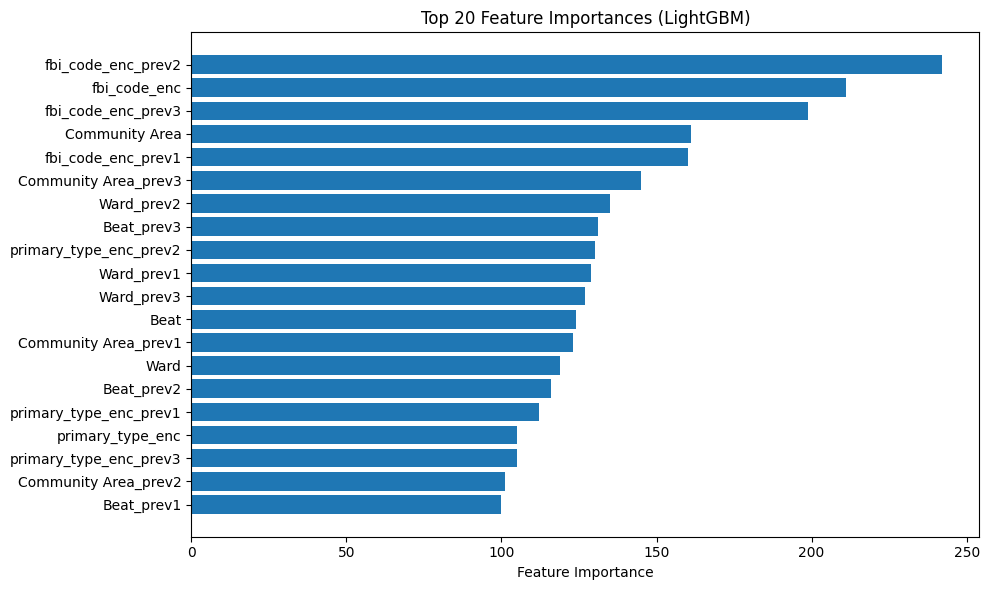

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

importances = lgbm.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


## LGBMRegressor + gridsearch

In [134]:
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lgbm = LGBMRegressor(random_state=42)

param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

best_lgbm = grid_search.best_estimator_

print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nLightGBM Regression (Optimized):")
print("Train R²:", best_lgbm.score(X_train_scaled, y_train))
print("Test  R²:", best_lgbm.score(X_test_scaled, y_test))

y_train_pred = best_lgbm.predict(X_train_scaled)
y_test_pred = best_lgbm.predict(X_test_scaled)

print("\nTraining Metrics:")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R²:", r2_score(y_train, y_train_pred))

print("\nTest Metrics:")
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R²:", r2_score(y_test, y_test_pred))

print("\nFeature Importances:")
for feat, imp in sorted(zip(X_train.columns, best_lgbm.feature_importances_),
                      key=lambdaFitting 3 folds for each of 81 candidates, totalling 243 fits

 x: -x[1]):
    print(f"{feat}: {imp}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2782
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 33
[LightGBM] [Info] Start training from score 1661.240250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

AttributeError: 'numpy.ndarray' object has no attribute 'columns'